In [12]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import time
import scipy
import os

from model.model import Model
from model.helpers import Helpers
from model.datahandler import DataHandler
from model.dihedralcalculator import DihedralCalculator

import txt_data_utils.data_transformer as dt

plt.style.use('ggplot')
%matplotlib inline

In [13]:
### DATA AND QUEUE CONFIGURATION ###
data_path = "path_to_the_data"
validation_casp = 'casp11'
# training_casps = ['casp7', 'casp8', 'casp9', 'casp10', 'casp11']
training_casps = ['casp11']
training_percentages = [30, 50]
max_len = None # max len of the protein taken into account

num_epochs = 500
batch_size= 32
capacity=1000

### MODEL CONFIGURATION ###
include_evo = True

model_type = 'cnn_big'
dropout_rate = 0.2

mode_a = 'alphabet' # regression or alphabet
mode_b = 'vectors' # angles or vectors

prediction_mode = mode_a + '_' + mode_b
n_clusters = 50 # only needed when prediction mode == alphabet

angularization_mode = None
regularize_vectors = None
if prediction_mode == 'regression_angles':
    angularization_mode = 'cos' # 'cos' or 'tanh', only matters in the regression_angles mode

if prediction_mode == 'regression_vectors':
    regularize_vectors = True # True or False, only matters in the regression_vectors mode

loss_mode = 'mae'
n_angles = 2

In [14]:
def extract_dataset(mode='validation', casp='casp11'):
    tf.reset_default_graph()
    
    data_handler = DataHandler(data_path=data_path,
                           casps=[casp],
                           num_epochs=1,
                           mode=mode)

    ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
        data_handler.generate_batches(batch_size = 1,
                                      capacity = 1000,
                                      max_protein_len = max_len)

    dihedral_calculator = DihedralCalculator()
    true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])

    with tf.Session() as sess:
        sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))

        coord = tf.train.Coordinator()  
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)

        try:
            ids_v, ohp_v, evo_v, tert_v, ter_mask_v, dih_v = [], [], [], [], [], []
            while not coord.should_stop(): 
                ids_, one_hot_primary_, evolutionary_, tertiary_, ter_mask_, pri_length_, keep_, true_dihedrals_ = sess.run([ids, one_hot_primary, evolutionary, tertiary, 
                                                                                                            ter_mask, pri_length, keep, true_dihedrals])

                ids_v.append(np.squeeze(ids_))
                ohp_v.append(np.squeeze(one_hot_primary_))
                evo_v.append(np.squeeze(evolutionary_))
                tert_v.append(np.squeeze(tertiary_))
                ter_mask_v.append(np.squeeze(ter_mask_))
                dih_v.append(np.squeeze(true_dihedrals_))

        except tf.errors.OutOfRangeError:
            print('Done')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

            # Wait for threads to finish.
            coord.join(threads)
            sess.close()

    prim, evo, dih, mask = dt.limit_length_and_pad(ohp_v, evo_v, dih_v, ter_mask_v, max_length=None)
#     x, y = np.concatenate([prim_v, evo_v], axis=2), dih_v
    return prim, evo, dih, mask

def get_predictions(protein_n, feed_list, checkpoint_path, to_calculate_list):
    prim, evo, dih, mask = feed_list
    with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, checkpoint_path)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord, sess=sess)

#         true, pred, mae_ = sess.run([true_dihedrals_masked, rad_pred_masked, mae_vec])
        
        if protein_n:
            feed_dict={
                       one_hot_primary: np.expand_dims(prim[protein_n], 0),
                       evolutionary: np.expand_dims(evo[protein_n], 0),
                       true_dihedrals: np.expand_dims(dih[protein_n,:,:n_angles], 0),
                       ter_mask: np.expand_dims(mask[protein_n],0)
                      }
        else:
            feed_dict={
                       one_hot_primary: prim,
                       evolutionary: evo,
                       true_dihedrals: dih[:,:,:n_angles],
                       ter_mask: mask
                      }

        ret_list = sess.run(to_calculate_list, 
                            feed_dict = feed_dict)

        coord.request_stop()
    return [np.array(el) for el in ret_list]

In [7]:
prim_valid, evo_valid, dih_valid, mask_valid = extract_dataset('validation', validation_casp)
prim_test, evo_test, dih_test, mask_test = extract_dataset('testing', validation_casp)
prim_valid.shape, prim_test.shape

['C:/Users/Michal/Downloads/casp11/validation/*']
Training samples available 224
Done
padded
['C:/Users/Michal/Downloads/casp11/testing/*']
Training samples available 81
Done
padded


((224, 698, 20), (81, 669, 20))

In [8]:
tf.reset_default_graph()

# define the training data paths and how many epochs they should be queued for
# by instantiating the DataHandler object that takes care of parsing
data_handler = DataHandler(data_path=data_path,
                           casps=training_casps,
                           percentages=training_percentages, 
                           num_epochs=num_epochs,
                           mode='training')

# use DataHandler to generate batches of specific size 
# and optional limit on protein length
# secondary structure is missing from the ProteinNet, thus the underscore
ids, one_hot_primary, evolutionary, _, tertiary, ter_mask, pri_length, keep =\
    data_handler.generate_batches(batch_size = batch_size,
                                  capacity = capacity,
                                  max_protein_len = max_len)

# convert euclidean coordinates to dihedral angles
dihedral_calculator = DihedralCalculator()
true_dihedrals = dihedral_calculator.dihedral_pipeline(tertiary, protein_length = tf.shape(one_hot_primary)[1])
true_dihedrals = true_dihedrals[:,:,:n_angles]

# set up placeholders with batch_size=None to be able to feed them with validation data
# they fall onto default coming from the queue if nothing is fed through feed_dict
true_dihedrals = tf.placeholder_with_default(true_dihedrals, shape=(None, None, n_angles))
true_vectors = Helpers.ang_to_vec_tf(true_dihedrals)
one_hot_primary = tf.placeholder_with_default(one_hot_primary, shape=(None, None, 20))
evolutionary = tf.placeholder_with_default(evolutionary, shape=(None, None, 21))
ter_mask = tf.placeholder_with_default(ter_mask, shape=(None, None))

# build a model and get predicted output
model = Model(n_angles=n_angles, 
              n_clusters=n_clusters,
              output_mask=ter_mask,
              model_type=model_type, 
              prediction_mode=prediction_mode,
              dropout_rate=dropout_rate,
              ang_mode=angularization_mode,
              regularize_vectors=regularize_vectors,
              loss_mode=loss_mode
            )

if include_evo:
    input_data = tf.concat([one_hot_primary, evolutionary], axis=2)
else:
    input_data = one_hot_primary

rad_pred_masked, vec_pred_masked = model.build_model(input_data)

true_dihedrals_masked, true_vectors_masked = model.mask_other([true_dihedrals, true_vectors])

loss, loss_vec = model.calculate_loss(true_dihedrals_masked, rad_pred_masked,
                                      true_vectors_masked, vec_pred_masked)

mae_vec = Helpers.loss360(true_dihedrals_masked, rad_pred_masked)

pcc = Helpers.pearson_tf(rad_pred_masked, true_dihedrals_masked)

# learning rate placeholder for adaptive learning rate
learning_rate = tf.placeholder(tf.float32, name='learning_rate')

# choose an optimizer to minimize the loss
global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss, global_step=global_step)

init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
try:
    n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
    print("Parameters:", n_parameters)
except:
    print("Couldn't calculate the number of parameters")

['C:/Users/Michal/Downloads/casp11/training/30/*', 'C:/Users/Michal/Downloads/casp11/training/50/*']
Training samples available 52280
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Users\Michal\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Parameters: 775130


Training loop

In [11]:
learning_rate_decay = 0.99
steps_to_print_after = 200
init_learning_rate = 0.001
load_checkpoint = False
save_checkpoint = False

def try_create_dir(path):
    try:
        os.mkdir(path)
        print("Created directory: " + path)
    except:
        print("Didn't create the directory: " + path)
        pass

try_create_dir('./checkpoints')
try_create_dir('./checkpoints/' + prediction_mode)
try_create_dir('./checkpoints/' + prediction_mode + '/tmp')

checkpoint_path = "./checkpoints/" + prediction_mode + "/tmp/"+loss_mode+"_"+str(n_angles)+"_model.ckpt"
print("checkpoint path:", checkpoint_path)

if 'lstm' in model_type:
    init_learning_rate = 0.001
    steps_to_print_after = 200
    
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    
    if load_checkpoint:
        saver.restore(sess, checkpoint_path)
    
    coord = tf.train.Coordinator()  
    threads = tf.train.start_queue_runners(coord=coord, sess=sess)

    try:
        step = 1
        
        # replaced every time the results are printed
        losses = []
        loss_vecs = []
        mae_vecs = []
        
        # filled out for final results
        train_losses = []
        train_maes = []
        val_losses = []
        val_maes = []
        pccs = []
        
        while not coord.should_stop():        
                
            _, true_dihedrals_, rad_pred_masked_, loss_, loss_vec_, mae_vec_ = sess.run([train_op, true_dihedrals, 
                                                                    rad_pred_masked, loss, loss_vec, mae_vec], 
                                                                    feed_dict={learning_rate: init_learning_rate})

            losses.append(loss_)
            loss_vecs.append(loss_vec_)
            mae_vecs.append(mae_vec_)
            
            if step % steps_to_print_after == 0:
                avg_loss, avg_loss_vec =  np.mean(losses), np.mean(np.array(loss_vecs), axis=0)
                train_losses.append(avg_loss_vec)
                train_maes.append(np.mean(np.array(mae_vecs), axis=0))
                print("Train loss:", avg_loss, avg_loss_vec)

                losses = []
                loss_vecs = []
                mae_vecs = []
                
                (true_dihedrals_masked_v, rad_pred_masked_v, 
                 loss_, loss_vec_, mae_vec_v) = sess.run([true_dihedrals_masked, rad_pred_masked, 
                                                   loss, loss_vec, mae_vec], 
                                                   feed_dict={
                                                           one_hot_primary: prim_valid,
                                                           evolutionary: evo_valid,
                                                           true_dihedrals: dih_valid[:,:,:n_angles],
                                                           ter_mask: mask_valid
                                                          })
                pcc = Helpers.pearson_numpy(np.squeeze(true_dihedrals_masked_v)[:,:n_angles], 
                                                               np.array(rad_pred_masked_v))
                print("Validation loss:", loss_, loss_vec_)
                print("Validation PCC:", pcc)
                print("Validation MAE:", mae_vec_v)
                             
                if (len(val_maes) > 1 and save_checkpoint and 
                    np.mean(val_maes[np.argmin(np.mean(val_maes, axis=1))]) > np.mean(mae_vec_v)):
                    save_path = saver.save(sess, checkpoint_path)
                    print("Model saved in path: %s" % save_path)
                
                val_maes.append(mae_vec_v)
                val_losses.append(loss_vec_)
                pccs.append(pcc)
                
            if step * batch_size > data_handler.training_samples:
                step = 0
                init_learning_rate = init_learning_rate * learning_rate_decay
                print("EPOCH. New learning rate:", init_learning_rate)
                
            step += 1

    except tf.errors.OutOfRangeError:
        print('Done training for %d epochs, %d steps.' % (num_epochs, step))
    finally:
        
        # When done, ask the threads to stop.
        coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        sess.close()

Didn't create the directory: ./checkpoints
Didn't create the directory: ./checkpoints/alphabet_vectors
Didn't create the directory: ./checkpoints/alphabet_vectors/tmp
checkpoint path: ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt


KeyboardInterrupt: 

In [11]:
train_maes = np.array(train_maes)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
val_maes = np.array(val_maes)
pccs = np.array(pccs)

In [9]:
true, pred, mae_vec_ = get_predictions(None, [prim_test, evo_test, dih_test, mask_test], 
                             checkpoint_path=checkpoint_path, 
                            to_calculate_list=[true_dihedrals_masked, rad_pred_masked, mae_vec])

pcc_test, mae_test = Helpers.pearson_numpy(true,pred), mae_vec_

INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt


In [17]:
pcc_test, np.rad2deg(mae_test)

([0.6619843, 0.70204836], array([20.318773, 30.573189], dtype=float32))

Plot the avg losses over time

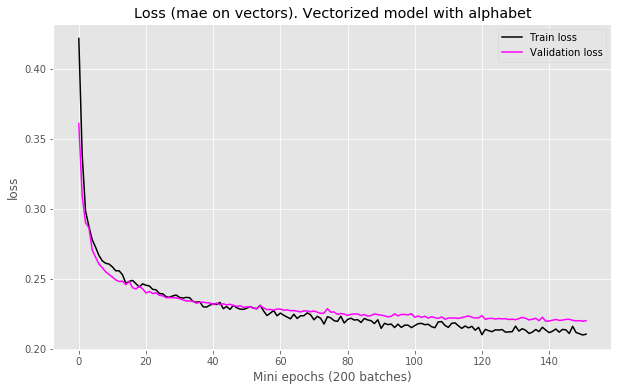

In [10]:
plt.figure(figsize=(10,6))
plt.plot(np.mean(train_losses.reshape(-1,4), axis=1), label='Train loss', color='black')
plt.plot(np.mean(val_losses.reshape(-1,4), axis=1), label='Validation loss', color='magenta')
# plt.plot(np.ones_like(val_maes[:,0]) * np.deg2rad(20), '--', label='RaptorX mae $\phi$', color='magenta')
plt.ylabel('loss')
plt.xlabel('Mini epochs (200 batches)')
plt.title("Loss (mae on vectors). Vectorized model with alphabet")
plt.legend()

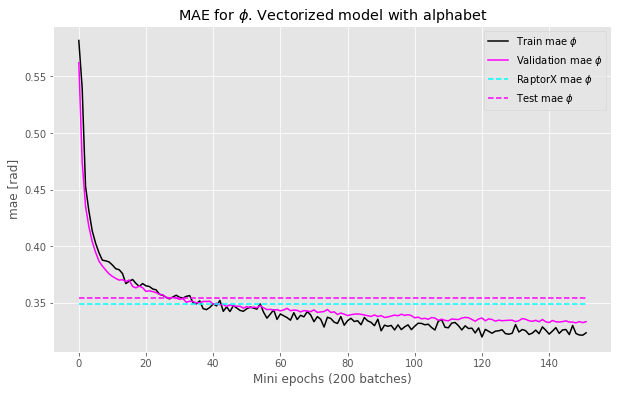

In [11]:
plt.figure(figsize=(10,6))
plt.plot(train_maes[:,0], label='Train mae $\phi$', color='black')
plt.plot(val_maes[:,0], label='Validation mae $\phi$', color='magenta')
plt.plot(np.ones_like(val_maes[:,0]) * np.deg2rad(20), '--', label='RaptorX mae $\phi$', color='cyan')
plt.plot(np.ones_like(val_maes[:,0]) * mae_test[0], '--', label='Test mae $\phi$', color='magenta')
plt.ylabel('mae [rad]')
plt.xlabel('Mini epochs (200 batches)')
plt.title("MAE for $\phi$. Vectorized model with alphabet")
plt.legend()

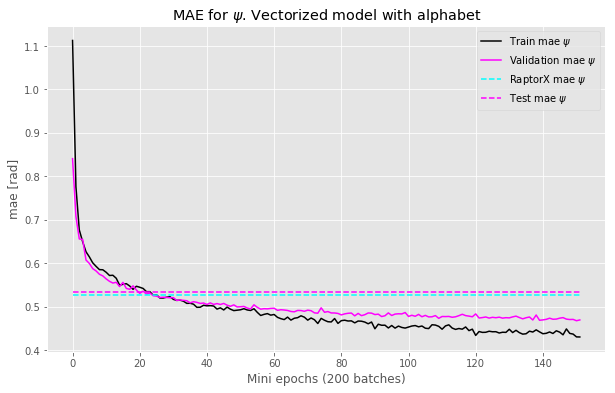

In [12]:
plt.figure(figsize=(10,6))
plt.plot(train_maes[:,1], label='Train mae $\psi$', color='black')
plt.plot(val_maes[:,1], label='Validation mae $\psi$', color='magenta')
plt.plot(np.ones_like(val_maes[:,1]) * np.deg2rad(30.14), '--', label='RaptorX mae $\psi$', color='cyan')
plt.plot(np.ones_like(val_maes[:,1]) * mae_test[1], '--', label='Test mae $\psi$', color='magenta')
plt.ylabel('mae [rad]')
plt.xlabel('Mini epochs (200 batches)')
plt.title("MAE for $\psi$. Vectorized model with alphabet")
plt.legend()

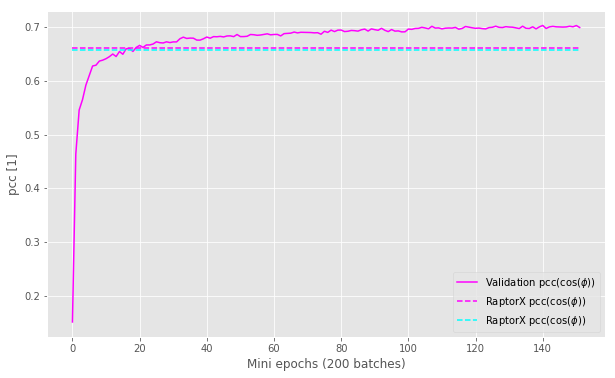

In [13]:
plt.figure(figsize=(10,6))

plt.plot(pccs[:,0], '-', color='magenta', label='Validation pcc(cos($\phi$))')
plt.plot(np.ones_like(pccs[:,0]) * pcc_test[0], '--', label='RaptorX pcc(cos($\phi$))', color='magenta')
plt.plot(np.ones_like(pccs[:,0]) * 0.6585, '--', label='RaptorX pcc(cos($\phi$))', color='cyan')
plt.ylabel('pcc [1]')
plt.xlabel('Mini epochs (200 batches)')

plt.legend()

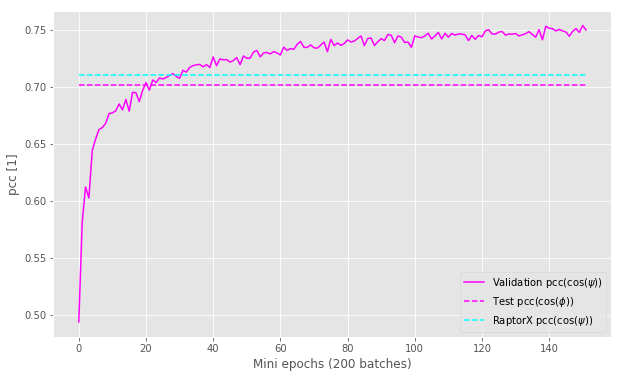

In [14]:
plt.figure(figsize=(10,6))

plt.plot(pccs[:,1], '-', color='magenta', label='Validation pcc(cos($\psi$))')
plt.plot(np.ones_like(pccs[:,1]) * pcc_test[1], '--', label='Test pcc(cos($\phi$))', color='magenta')
plt.plot(np.ones_like(pccs[:,1]) * 0.7103, '--', label='RaptorX pcc(cos($\psi$))', color='cyan')
plt.xlabel('Mini epochs (200 batches)')
plt.ylabel('pcc [1]')
plt.legend()

INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt


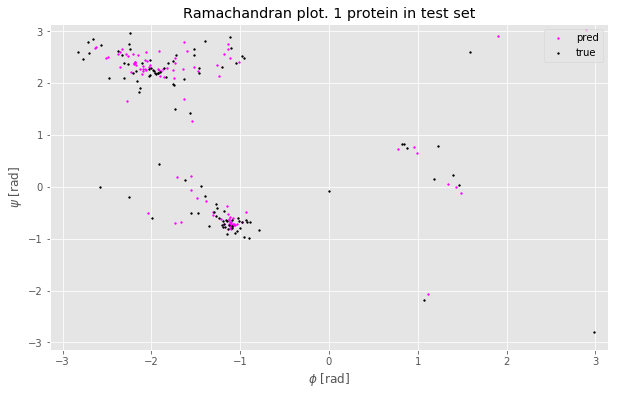

In [12]:
true, pred = get_predictions(34, [prim_test, evo_test, dih_test, mask_test], 
                             checkpoint_path=checkpoint_path, to_calculate_list=[true_dihedrals_masked, rad_pred_masked])

plt.figure(figsize=(10,6))

phi, psi = np.split(pred, n_angles, -1)
plt.scatter(phi[:], psi[:], s=3, label='pred', color='magenta')

phi, psi = np.split(true, n_angles, -1)
plt.scatter(phi[:], psi[:], s=3, label='true', color='black')

plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel('$\phi$ [rad]')
plt.ylabel('$\psi$ [rad]')
plt.title("Ramachandran plot. 1 protein in test set")
plt.legend(loc=1)

In [24]:
all_true, all_pred, all_mae = [], [], []
for protein_n in range (prim_test.shape[0]):
    true, pred, mae_ = get_predictions(protein_n, [prim_test, evo_test, dih_test, mask_test], 
                             checkpoint_path=checkpoint_path, to_calculate_list=[true_dihedrals_masked, rad_pred_masked, mae_vec])
    all_true.append(true), all_pred.append(pred), all_mae.append(mae_)

INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/alph

In [27]:
def _np_array(the_list):
    return [np.array(el) for el in the_list]

In [29]:
all_true, all_pred, all_mae = _np_array([all_true, all_pred, all_mae])

In [36]:
all_mae_deg = np.rad2deg(all_mae)

In [39]:
mask_test.shape

(81, 669)

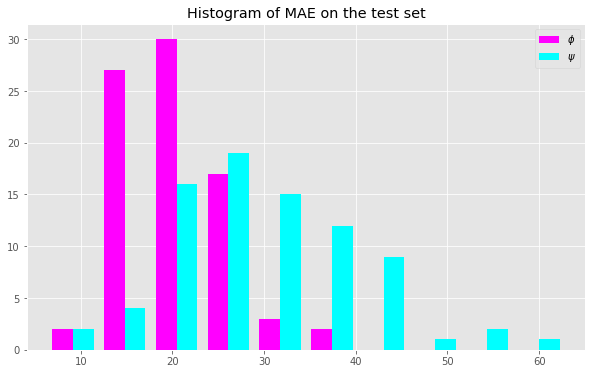

In [137]:
plt.figure(figsize=(10,6))
plt.hist(all_mae_deg, label=['$\phi$', '$\psi$'], color=['magenta', 'cyan'])
plt.title('Histogram of MAE on the test set')
plt.legend()

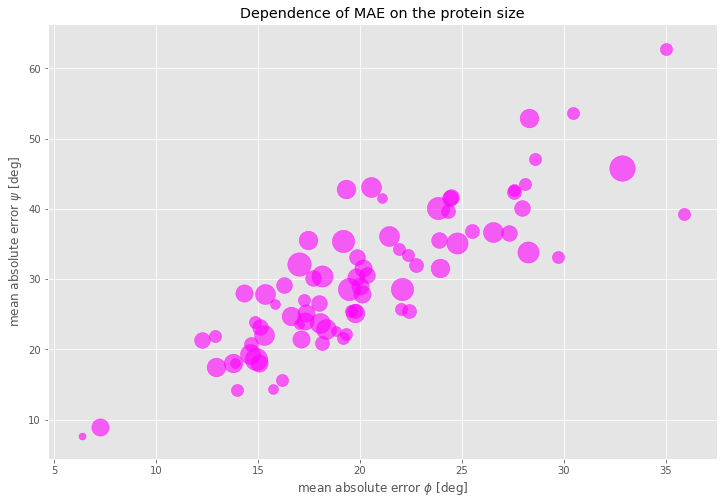

In [138]:
plt.figure(figsize=(12,8))
for i in range(all_mae_deg.shape[0]):
    mask_i = mask_test[i]
    size = (int(np.sum(mask_i)/50) +1)* 50
    color = int(np.mean(all_mae_deg[i]))
    plt.scatter([all_mae_deg[i,0]], [all_mae_deg[i,1]], s=size, c='magenta', alpha=0.6)
    plt.xlabel('mean absolute error $\phi$ [deg]')
    plt.ylabel('mean absolute error $\psi$ [deg]')
    plt.title("Dependence of MAE on the protein size")

In [158]:
scipy.stats.pearsonr(np.sum(mask_test, axis=1), np.mean(all_mae, 1))

(0.08548929576549387, 0.4479508556092451)

(669,)


(<matplotlib.collections.PathCollection at 0x7f8825dc1208>, (52, 135))

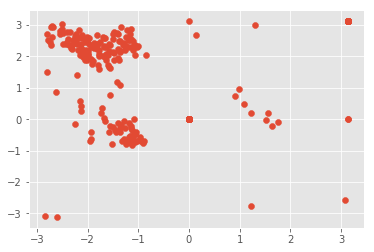

In [182]:
plt.scatter(dih_test[0,:,0], dih_test[0,:,1]), count_alpha_beta(dih_test[0])

In [184]:
def count_alpha_beta(dih_protein):
    x = dih_protein[:,0]
#     print(x.shape)
    y = dih_protein[:,1]
    beta = np.logical_and.reduce([x < -0.5, x > -3, y > 1, y <= np.pi])
    alpha = np.logical_and.reduce([x < -0.5, x > -3, y < 1, y >= -1.2])
    return np.sum(alpha), np.sum(beta)

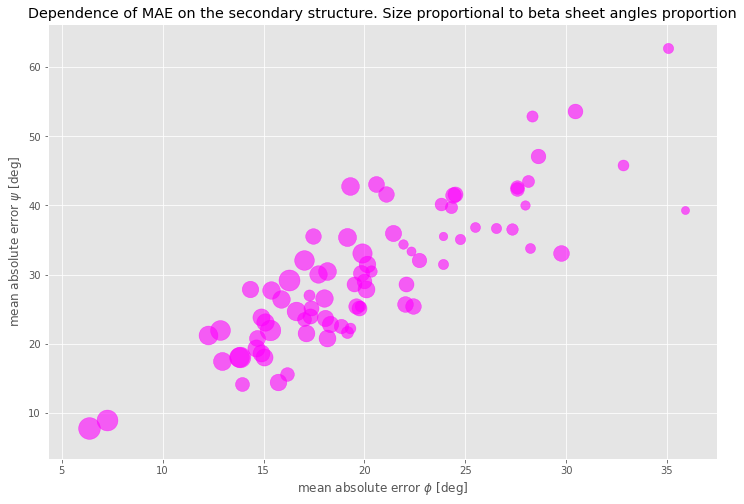

In [211]:
plt.figure(figsize=(12,8))
for i in range(all_mae_deg.shape[0]):
    val_i = dih_test[i]
    protein_size = np.sum(mask_test[i]) + 1
    alpha,beta = count_alpha_beta(val_i)
    size = (beta+1) / protein_size
#     print(size)
#     print(np.std(val_i))
#     size = (int(np.std(val_i)**2)+1) * 100
    color = int(np.mean(all_mae_deg[i]))
    plt.scatter([all_mae_deg[i,0]], [all_mae_deg[i,1]], s=size*500, c='magenta', alpha=0.6)
    plt.xlabel('mean absolute error $\phi$ [deg]')
    plt.ylabel('mean absolute error $\psi$ [deg]')
    plt.title("Dependence of MAE on the secondary structure. Size proportional to beta sheet angles proportion")

In [ ]:
plt.figure(figsize=(12,8))
for i in range(all_mae_deg.shape[0]):
    val_i = dih_test[i]
#     print(np.std(val_i))
    size = (int(np.std(val_i)**2)+1) * 100
    color = int(np.mean(all_mae_deg[i]))
    plt.scatter([all_mae_deg[i,0]], [all_mae_deg[i,1]], s=size, c='magenta', alpha=0.6)
    plt.xlabel('mean absolute error $\phi$ [deg]')
    plt.ylabel('mean absolute error $\psi$ [deg]')
    plt.title("Dependence of MAE on the standard deviation of true protein angles")

INFO:tensorflow:Restoring parameters from ./checkpoints/alphabet_vectors/tmp/mae_2_model.ckpt


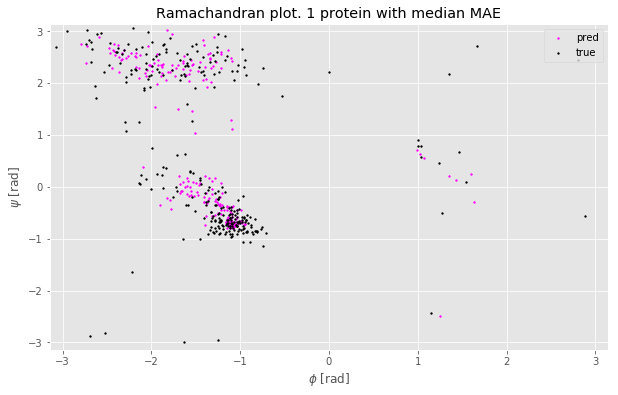

In [150]:
true, pred = get_predictions(np.argsort(np.mean(all_mae, axis=1))[len(np.mean(all_mae, axis=1))//2], [prim_test, evo_test, dih_test, mask_test], 
                             checkpoint_path=checkpoint_path, to_calculate_list=[true_dihedrals_masked, rad_pred_masked])

plt.figure(figsize=(10,6))

phi, psi = np.split(pred, n_angles, -1)
plt.scatter(phi[:], psi[:], s=3, label='pred', color='magenta')

phi, psi = np.split(true, n_angles, -1)
plt.scatter(phi[:], psi[:], s=3, label='true', color='black')

plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel('$\phi$ [rad]')
plt.ylabel('$\psi$ [rad]')
plt.title("Ramachandran plot. 1 protein with median MAE")
plt.legend(loc=1)

In [ ]:
plt.figure(figsize=(12,8))
for i in range(all_mae_deg.shape[0]):
    val_i = dih_test[i]
#     print(np.std(val_i))
    size = (int(np.std(val_i)**2)+1) * 100
    color = int(np.mean(all_mae_deg[i]))
    plt.scatter([all_mae_deg[i,0]], [all_mae_deg[i,1]], s=size, c='magenta', alpha=0.6)
    plt.xlabel('mean absolute error $\phi$ [deg]')
    plt.ylabel('mean absolute error $\psi$ [deg]')